# HW 2 - Naive Bayes in Hadoop MR
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code. __Please refer to the `README` for homework submission instructions.__ 

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [5]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HDFS_DIR = "/user/root/HW2"
HOME_DIR = "" # FILL IN HERE eg. /media/notebooks/Assignments/HW2

In [7]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [8]:
# data path
ENRON = "data/enronemail_1h.txt"

# Question 1: Hadoop MapReduce Key Takeaways.  

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __b) short response:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

* __c) short response:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ _what level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

* __d) short response:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

* __e) short response:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

### Q1 Student Answers:

> __a)__ Hadoop MapReduce is based upon the Functional Programming paradigm.  This is exemplified in the hierarchical functions used in MapReduce, namely the mapper and reducer.  It is also exemplified in the deterministic behavior of MapReduce, namely that results should be consistent provided the input is indentical.

> __b)__ Hadoop Shuffle is the "heart and soul" of the MapReduce algorithm and refers to the data partitioning, shuffling, and sorting that occurs between the mapping and reducing phase.  It is potentially costly from a time and computation standpoint when this step is not properly optimized using combiners when appropriate.  

> __c)__ The input and output record format of a combiner need to be the same because there is no guarantee that the MapReduce job will utilize the combiner.  Therefore, the output format from the Mapper and the input format for the Reducer must be consistent whether or not a combiner is utilized.

> __d)__ The parallelization of a Hadoop Streaming job can be controlled by adjusting the data block size or the JobConf's conf.setNumMapTasks(int num) setting to control the number of mappers available.  Also, the number of reducers can be controlled using the JobConf's conf.setNumReduceTasks(int num) setting.  

> __e)__ The change in the availability of large scale data sets prompted the creation of parallel computation frameworks like Hadoop.  These parallel computation frameworks were able to be created by leveraging commodity hardware and advances in storage technologies for disk and RAM to process higher quantities of data.

# Question 2: MapReduce Design Patterns.  

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) short response:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter?

* __b) short response:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

* __c) short response:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 

### Q2 Student Answers:

> __a)__ In the context of Hadoop Streaming, counters are used for keeping track of how many input key-value pairs have been processed.  They are useful for reducing the memory consumed by the mapper and combiner processes in MapReduce.  Hadoop provides counters like the MapReduce Task and MapReduce Job counters.  Custom counters can be created by using the user defined Dynamic counters.   

> __b)__ Composite keys have multiple identifying components which can be used for grouping.  An example of a composite key is a Sensor ID and Timestamp being combined into one composite key.  They are useful for allowing Mappers and Reducers to group based upon multiple identifying components.  They relate to custom partitioning because the keys are what are typically used for partitioning, so a composite key would be another key type that could be partioned on.

> __c)__ The order inversion pattern refers to the pattern where accessing the result of a computation in the reducer (e.g. aggregate statistic) happens before processing the data needed for that computation.  This solves the burden of having to pass over the data twice for processing.  It can be implemented by modifying the mapper function to output a co-occuring key pair and defining a custom partitioner to ensure all partial keys are sent to the same reduce.


# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbirtary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) short response:__ What is the difference between a partial sort, an unordered total sort, and a total order sort? From the programmer's perspective, what does total order sort allow us to do that we can't with unordered total? Why is this important with large datasets?

* __b) short response:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) short response:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) short response:__ Explain why we need to use an inverse hash code function.

* __e) short response:__ Where does this function need to be located so that a Total Order Sort can be performed?

### Q3 Student Answers:

> __a)__ A partial sort is the default behavior for most MapReduce frameworks and means that the keys are sorted in each individual partition file.  An unordered total sort is where all keys are sorted across all partition files, but the partition files themselves are not stacked/assigned in order.  A total order sort is where all keys are sorted across partition files in the correct order.  Total Order Sort allows a programmer to utilize algorithms which require sorted input  or prefer it for computational efficiency.  This is extremely important for large data sets because any tangible means of reducing the Big O complexity of an algorithm that will be processing the output of an MapReduce job will result in saved resources for the programmer and their project.  

> __b)__ The shuffle phase of MapReduce is leveraged to implement Total Order Sort.  The default partioner and sort methods must be changed since they would default to providing partial sort results otherwise.  Note, combiner can be modified for efficiency improvements, but is not required for Total Order Sort to be implemented.

> __c)__ Hadoop Streaming Jobs needs Hadoop Streaming parameters to be specified (e.g. KeyFieldBasedPartitioner, KeyFieldBasedComparator) and configured for custom sorting and partioning required for Total Order Sort.  

> __d)__ The inverse hash code function is needed to preserve partition key ordering and is used to find the correct partition index.

> __e)__ The function needs to be provided as the KeyBasedPartitioner argument to Hadoop Streaming so that Total Order Sort can be performed.

# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personlized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [5]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
!head -n 5 {ENRON} | cut -c-100

0001.1999-12-10.farmer	0	 christmas tree farm pictures	NA
0001.1999-12-10.kaminski	0	 re: rankings	 thank you.
0001.2000-01-17.beck	0	 leadership development pilot	" sally:  what timing, ask and you shall receiv
0001.2000-06-06.lokay	0	" key dates and impact of upcoming sap implementation over the next few week
0001.2001-02-07.kitchen	0	 key hr issues going forward	 a) year end reviews-report needs generating 


In [6]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l {ENRON}

100 data/enronemail_1h.txt


In [7]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir {HDFS_DIR}

mkdir: `/user/root/HW2': File exists


In [8]:
# load the data into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal {ENRON} {HDFS_DIR}/enron.txt

copyFromLocal: `/user/root/HW2/enron.txt': File exists


# Question 4:  Enron Ham/Spam EDA.
Before building our classifier, lets get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in real emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output of your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) code:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected then run the provided Hadoop streaming command to apply your analysis to the Enron data.


* __b) code + short response:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)


* __c) short response:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Briefly explain why or why not.


* __d) code + short response:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reodering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)


* __ e) code:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Edit your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

### Q4 Student Answers:
> __b)__ 

        assistance	0	2
        assistance	1	8  

> __c)__ Yes, we could have added a parameter to sort by count.  The unix command sort with the -t and -k flag can be used to sort by any field, thus there should be a way to do this in Map Reduce.  The Comparator parameters, namely keycomparator, can be used for sorting and secondary sorting.

> __d)__ The top 10 words of each class can be obtained by outputting the first 10 lines of each partition file.  This achieves the goal since the partition is on each class (spam/ham) and the files are ordered by count already.

In [14]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [17]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo -e "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

title	1	1
body	1	1
title	0	1
body	0	1


In [24]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo -e "one	1	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

one	0	3
one	1	0
two	0	1
two	1	0


In [96]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [97]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob5969308167392172532.jar tmpDir=null
19/05/22 04:25:05 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/22 04:25:05 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/22 04:25:06 INFO mapred.FileInputFormat: Total input paths to process : 1
19/05/22 04:25:07 INFO mapreduce.JobSubmitter: number of splits:2
19/05/22 04:25:07 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1558412502655_0020
19/05/22 04:25:07 INFO impl.YarnClientImpl: Submitted application application_1558412502655_0020
19/05/22 04:25:07 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1558412502655_0020/
19/05/22 04:25:07 INFO mapreduce.Job: Running job: job_1558412502655_0020
19/05/22 04:25:15 INFO mapreduce.Job: Job job_1558412502655_0020 running in uber mode : false
19/05/22 04:25:15 INFO mapreduce.Job:  map 0% reduce 0%
19/05

In [98]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [99]:
# part b - write your grep command here
!cat EnronEDA/results.txt | grep assistance

assistance	0	2
assistance	1	8


In [103]:
# part d/e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

Deleted /user/root/HW2/eda-sort-output


In [101]:
# part d/e - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.partition.keypartitioner.options=-k2,2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2n -k3,3nr" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH} \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob3039855306680964058.jar tmpDir=null
19/05/22 04:25:56 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/22 04:25:56 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/22 04:25:57 INFO mapred.FileInputFormat: Total input paths to process : 2
19/05/22 04:25:57 WARN hdfs.DFSClient: Caught exception 
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:969)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.endBlock(DFSOutputStream.java:707)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:896)
19/05/22 04:25:58 INFO mapreduce.JobSubmitter: number of splits:2
19/05/22 04:25:58 INFO mapreduce.JobSubmitter: Submitting 

In [102]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head


===== part-00000=====

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	

===== part-00001=====

the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153	


__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners.
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) short response:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received be the reducers. In the context of word counting what does this number represent practically?

* __b) code:__ Note that we wrote the reducer in question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from question 4a with this combining added.

* __c) short response__: Report the number of records emitted by your mappers in part b and the number of records received by your reducers. Compare your results here to what you saw in part a. Explain.

* __d) short response__: Describe a scenario where using a combiner would _NOT_ improve the efficiency of the shuffle stage. Explain. [__`BONUS:`__ how does increasing the number of mappers affect the usefulness of a combiner?]

### Q5 Student Answers:
> __a)__ Map output records=31490, Reduce input records=31490... These numbers loosely represent the number of unique words, although not quite due to the likely duplicates across the mapper nodes.  They also represent the total hash (key/value) size that the shuffle portion of MapReduce will have to process.  

> __c)__ Map output records=31490, Reduce input records=13096... The number of reduce input records from part b is much less than from part a.  The addition of the combiner optimized the shuffling phase of MapReduce so that keys were combined before being sent to the reducers, thus the reduce input records field was less (not equal to) than the map output record value.

> __d)__ One scenario where a combiner would not improve the shuffle stage is when the number of mappers starts to come closer in value to its number of keys.  Since the purpose of the combiner is to combine the values for similar keys in an individual mapper, this efficiency deminishes as more mappers are added.  The worst case scenario in terms of combiner optimization would be an equal number of mappers to keys.  As the number of mappers increases, the usefulness of a combiner decreases.

In [104]:
# part b - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [105]:
# part b - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -combiner reducer.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob8445651439567434510.jar tmpDir=null
19/05/22 04:41:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/22 04:41:04 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/22 04:41:05 INFO mapred.FileInputFormat: Total input paths to process : 1
19/05/22 04:41:05 INFO mapreduce.JobSubmitter: number of splits:2
19/05/22 04:41:05 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1558412502655_0022
19/05/22 04:41:05 INFO impl.YarnClientImpl: Submitted application application_1558412502655_0022
19/05/22 04:41:05 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1558412502655_0022/
19/05/22 04:41:05 INFO mapreduce.Job: Running job: job_1558412502655_0022
19/05/22 04:41:15 INFO mapreduce.Job: Job job_1558412502655_0022 running in uber mode : false
19/05/22 04:41:15 INFO mapreduce.Job:  map 0% reduce 0%
19/05

# Question 6: Document Classification Task Overview.
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:
* __a) short response:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.


* __b) short response:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How will we would estimate these values from a training corpus? How many passes over the data would we need to make to retrieve this information for all classes and all words?


* __c) hand calculations:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]


* __d) hand calculations:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and   $\LaTeX$ in the space provided or by embedding an image of your hand written work.


* __e) short response:__ Compare the classification you get from this unsmoothed model in `d`/`e` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?

### Q6 Student Answers:
> __a)__ The 2 pieces of information required to calculate $\hat{P}(c|d)$ are ${P}(t_k|c)$ and ${P}(c)$.  The first variable represents the conditional probability of term $t_k$ occurring in a class c document, and the second variable represents the prior probability of a document occurring in class c.

> __b)__ In the Enron example, ${P}(t_k|c)$ is exemplified by the % probability of a term like 'dear' occuring in a spam (i.e. 1) class document.  ${P}(c)$ is exemplified by the prior % probability of a new document being in the spam (i.e. 1) class.  These values can be estimated from a training corpus by running a similar MapReduce job to the one from Question 4, calculating the frequency that each word comes up in a class and tallying the cases of each class.  We would need to make 2 passes over the data in order to retrieve this information as long as we had sufficient RAM to store all key/values for each word per class.  The first pass would be to tally up word counts per class, and the second would be to calculate the frequencies for each word.  This algorithm would have O(2n) complexity which simplifies to O(n).

> __c)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!
Opting to embed below

> __d)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!
Opting to embed below

> __e)__ While both models show low likelihood that the document is not Chinese, the results from my unsmoothed model show much higher confidence that the document is Chinese than the smoothed model.  Therefore, smoothing seems to prevent overconfidence in model predictions and will help to generalize the model.


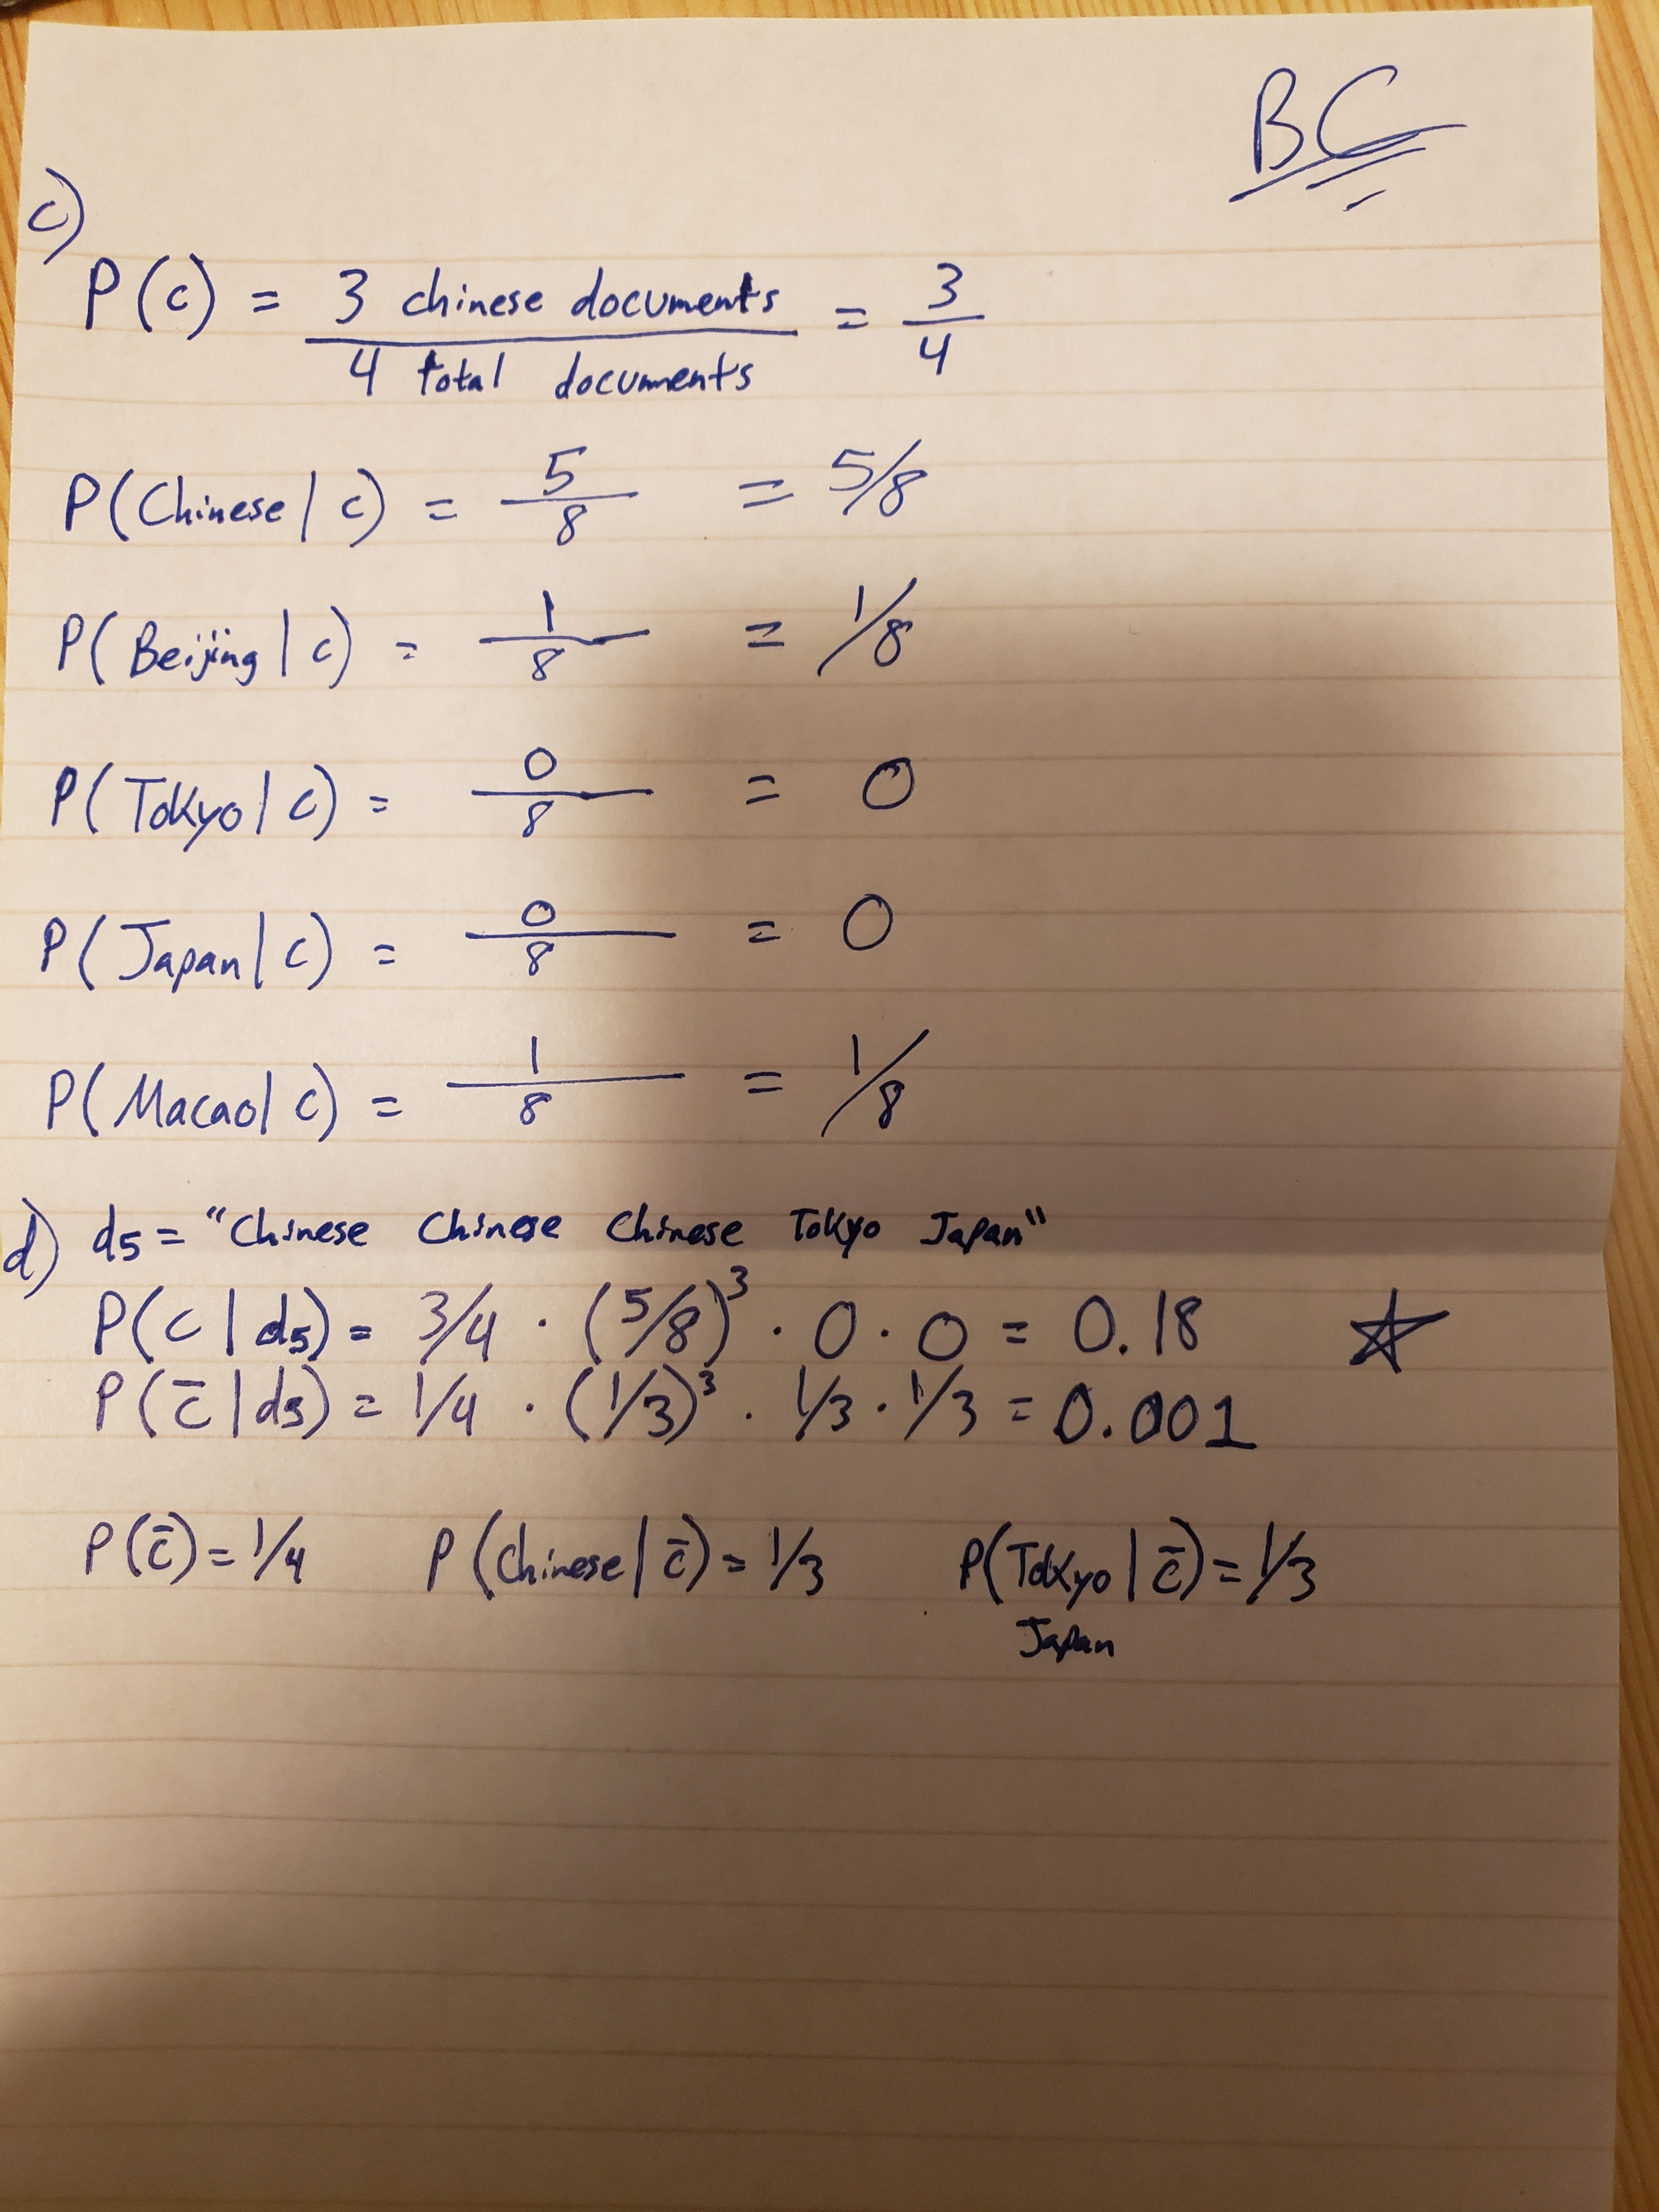

In [1]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="Q6.jpg")

# Question 7: Naive Bayes Inference.
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short response:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short response:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) short response:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?


* __d) short response:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? when would it be unwise?


* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]


* __f) short response:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? What could the mappers still do? What key-value structure would they emit? What would the reducers have to do as a last step?

### Q7 Student Answers:
> __a)__ The keys are each word found in the corpus, and the values are a comma delimitted list of 4 floats representing in order *appearances in non-Chinese documents*, *appearances in Chinese documents*, *conditional probability for non-Chinese*, and *conditional probability for Chinese*.  The *ClassPriors* key is the outlier.  The first 2 values are useful for debugging, but only the conditional probabilities and the ClassPriors are needed for inference.

> __b)__ Log probabilities are used here because the float multiplication could otherwise result in floating point underflow.  If we were working with an unsmoothed model, we would have to watch out for taking the logarithm of zero since this isn't a valid math operation.  

> __c)__ We should treat the word in a way that it does not increase the probability of either class, so the class conditional probability should be 0.

> __d)__ Loading a model into memory during the inference portion our our problem does break a functional programming principle.  Immutability, the quality of not changing overtime or unable to be changed, would be violated each time we train our model again.  This kind of memory usage would be extremely unwise if the model were particularly large, specifically if it took more memory than is available in a data block.  It would be wise to load the model into memory for scalability if the model + input data is less than the size of the mapper node.  

> __e)__ Complete the coding portion of this question before answering 'f'.

> __f)__ Our algorithm design could change so that each node contributes a sequential portion (e.g. alphabetical) of the corpora.  The mappers could still be used in the same manner with a slightly modified output to allow partitioning based upon the first letter of each word.  To be clear, the mappers could for example partition the corpora into 26 groups where each group contains only words that start with a specific letter of the alphabet.  The mappers new key-value structure would include a key with the partition conveying the letter of the alphabet, and values which consist of words, class, and counts.  The reducers would have to combine the words of their given partition and obtain the term count and frequency per class.


Run these cells to create the example corpus and model.

In [9]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Overwriting NaiveBayes/chineseTrain.txt


In [10]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Overwriting NaiveBayes/chineseTest.txt


In [11]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

Overwriting NBmodel.txt


In [17]:
# load the data files into HDFS
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

Your work for `part e` starts here:

In [13]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [35]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


In [18]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

Deleted /user/root/HW2/chinese-output


In [32]:
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/chineseTest.txt \
  -output {HDFS_DIR}/chinese-output \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob5990047941825762841.jar tmpDir=null
19/05/23 04:39:21 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/23 04:39:22 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/05/23 04:39:23 INFO mapred.FileInputFormat: Total input paths to process : 1
19/05/23 04:39:23 INFO mapreduce.JobSubmitter: number of splits:2
19/05/23 04:39:23 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1558552152193_0005
19/05/23 04:39:24 INFO impl.YarnClientImpl: Submitted application application_1558552152193_0005
19/05/23 04:39:24 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1558552152193_0005/
19/05/23 04:39:24 INFO mapreduce.Job: Running job: job_1558552152193_0005
19/05/23 04:39:32 INFO mapreduce.Job: Job job_1558552152193_0005 running in uber mode : false
19/05/23 04:39:32 INFO mapreduce.Job:  map 0% reduce 0%
19/05

In [33]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [34]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737811	0
d8	0	-4.394449154674438	-5.565796731681498	0
d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training.
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 

__IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. [`HINT:` _You will need to implement Total Order Sort_ - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)]


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 5.


* __c) short response:__ We saw in Question 6 that adding Laplace +1 smoothing makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].


* __d) short response:__ There are three approaches that we could take to handle the extra piece of information you identified in `c`: 1) we could hard code it into our reducer (_where would we get it in the first place?_). Or 2) we could compute it inside the reducer which would require storing some information in memory (_what information?_). Or 3) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options. BONUS: which of these options is incompatible with using multiple reducers?


* __e) code + short response:__ Choose one of the 3 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). [`HINT:` _don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications_].

### Q8 Student Answers:
> __ c)__ In order to add Laplace +1 smoothing, we could also need to calculate the number of unique words in our vocabulary.  In our previous MNB model, we relied on total words in each class, but not the unique words of the vocabulary.  

> __ d)__ Option 1 is unideal because it is not flexible to new data being used in the model. This option could be implemented by adding a pre-processing step which makes a hash of all words in the corpus, counts the keys, and "hard coded" by adding a line to the corpus as a key similar to how "!total" is used.  More simply, this example has a small corpora so we could simply just count up the unique words as well.  Option 2 is unideal because it could easily run into insufficient memory issues with a large enough corpora.  Note, this is the option that would not work with multiple reducers since it relies on keeping a list of all unique words in memory for a single reducer.  Option 3 is unideal because it increases the computational overhead of our algorithm by introducing an entirely new process for accomplishing this task.  

> __ e)__ I elected to implement Option 1 since I already have the means of obtaining the number of unique words in the corpora.  I did not consider Option 2 since we were given explicit instructions to make a solution that can use multiple reducers.  Option 3 is a fine option, and ultimately would require another process/program to be written, so I refrained from this option for now.  

In [43]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py
!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

=========== MAPPER DOCSTRING ============
Mapper reads in text documents and emits word counts by class.
    
INPUT:
    ID \t class \t text
OUTPUT:
    partition \t word \t class \t count
=========== REDUCER DOCSTRING ============
Reducer aggregates word counts by class and emits frequencies.
    
INPUT:
    partition \t word \t class \t count
OUTPUT:
    word \t non_chinese_count,chinese_count,non_chinese_cond_prob,chinese_cond_prob


__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [94]:
# part b - write a unit test for your mapper here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py

A	chinese	1	1
A	beijing	1	1
A	chinese	1	1
A	chinese	1	1
A	chinese	1	1
C	shanghai	1	1
A	chinese	1	1
B	macao	1	1
C	tokyo	0	1
B	japan	0	1
A	chinese	0	1
A	!totaldocs	0	1
A	!totaldocs	1	3
A	!totalwords	0	3
A	!totalwords	1	8
B	!totaldocs	0	1
B	!totaldocs	1	3
B	!totalwords	0	3
B	!totalwords	1	8
C	!totaldocs	0	1
C	!totaldocs	1	3
C	!totalwords	0	3
C	!totalwords	1	8


In [54]:
# part b - write a unit test for your reducer here
!echo -e "A	!totalwords	0	1\nB	!totaldocs	1	1\nA	!totalwords	1	1\nB	!totaldocs	0	1\nA	one	1	1\nA	one	0	1\nB	one	0	1\nC	two	0	1" | NaiveBayes/train_reducer.py

one	2.0,1.0,2.0,1.0
two	1.0,0,2.0,1.0
ClassPriors	1.0,1.0,0.5,0.5


In [55]:
# part b - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 | NaiveBayes/train_reducer.py 

beijing	0,1.0,0.0,0.125
chinese	1.0,5.0,0.3333333333333333,0.625
japan	1.0,0,0.3333333333333333,0.0
macao	0,1.0,0.0,0.125
shanghai	0,1.0,0.0,0.125
tokyo	1.0,0,0.0,0.125
ClassPriors	3.0,9.0,0.25,0.75


In [68]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/unsmoothed-chinese-nb-model

Deleted /user/root/HW2/unsmoothed-chinese-nb-model


In [69]:
# part b - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/unsmoothed-chinese-nb-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob1799957511251418514.jar tmpDir=null
19/06/02 02:06:46 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 02:06:46 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 02:06:47 INFO mapred.FileInputFormat: Total input paths to process : 1
19/06/02 02:06:47 INFO mapreduce.JobSubmitter: number of splits:2
19/06/02 02:06:47 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1559427993181_0024
19/06/02 02:06:47 INFO impl.YarnClientImpl: Submitted application application_1559427993181_0024
19/06/02 02:06:47 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1559427993181_0024/
19/06/02 02:06:47 INFO mapreduce.Job: Running job: job_1559427993181_0024
19/06/02 02:06:52 INFO mapreduce.Job: Job job_1559427993181_0024 running in uber mode : false
19/06/02 02:06:52 INFO mapreduce.Job:  map 0% reduce 0%
19/06

In [70]:
# part b - extract your results (i.e. model) to a local file
!rm NaiveBayes/Q8Unsmoothed/model.txt
!touch NaiveBayes/Q8Unsmoothed/model.txt
!hdfs dfs -cat {HDFS_DIR}/unsmoothed-chinese-nb-model/part-000* > NaiveBayes/Q8Unsmoothed/model.txt

In [71]:
# part b - print your model so that we can confirm that it matches expected results
!cat NaiveBayes/Q8Unsmoothed/model.txt

japan	1.0,0,0.3333333333333333,0.0
macao	0,1.0,0.0,0.125
ClassPriors	1.0,3.0,0.25,0.75
shanghai	0,1.0,0.0,0.125
tokyo	1.0,0,0.3333333333333333,0.0
ClassPriors	1.0,3.0,0.25,0.75
beijing	0,1.0,0.0,0.125
chinese	1.0,5.0,0.3333333333333333,0.625
ClassPriors	1.0,3.0,0.25,0.75


__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [88]:
# part e - write a unit test for your NEW reducer here
!echo -e "A	!totalwords	0	1\nB	!totaldocs	1	1\nA	!totalwords	1	1\nB	!totaldocs	0	1\nA	one	1	1\nA	one	0	1\nB	one	0	1\nC	two	0	1" | NaiveBayes/train_reducer_smooth.py

one	2.0,1,0.42857142857142855,0.2857142857142857
two	1,0,0.2857142857142857,0.14285714285714285
ClassPriors	1.0,1.0,0.5,0.5


In [97]:
# part e - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 | NaiveBayes/train_reducer_smooth.py 

beijing	0,1,0.1111111111111111,0.14285714285714285
chinese	1,5.0,0.16666666666666666,0.2727272727272727
japan	1,0,0.16666666666666666,0.045454545454545456
macao	0,1,0.06666666666666667,0.06666666666666667
shanghai	0,1,0.06666666666666667,0.06666666666666667
tokyo	1,0,0.13333333333333333,0.03333333333333333
ClassPriors	3.0,9.0,0.25,0.75


In [90]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/smoothed-chinese-nb-model

Deleted /user/root/HW2/smoothed-chinese-nb-model


In [91]:
# part e - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer_smooth.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/smoothed-chinese-nb-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob4619008696521435850.jar tmpDir=null
19/06/02 02:43:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 02:43:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 02:43:04 INFO mapred.FileInputFormat: Total input paths to process : 1
19/06/02 02:43:04 INFO mapreduce.JobSubmitter: number of splits:2
19/06/02 02:43:04 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1559427993181_0027
19/06/02 02:43:04 INFO impl.YarnClientImpl: Submitted application application_1559427993181_0027
19/06/02 02:43:04 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1559427993181_0027/
19/06/02 02:43:04 INFO mapreduce.Job: Running job: job_1559427993181_0027
19/06/02 02:43:11 INFO mapreduce.Job: Job job_1559427993181_0027 running in uber mode : false
19/06/02 02:43:11 INFO mapreduce.Job:  map 0% reduce 0%
19/06

In [92]:
# part e - extract your results (i.e. model) to a local file
!rm NaiveBayes/Q8Smoothed/model.txt
!touch NaiveBayes/Q8Smoothed/model.txt
!hdfs dfs -cat {HDFS_DIR}/smoothed-chinese-nb-model/part-000* > NaiveBayes/Q8Smoothed/model.txt
!cat NaiveBayes/Q8Smoothed/model.txt

japan	1,0,0.2222222222222222,0.07142857142857142
macao	0,1,0.1111111111111111,0.14285714285714285
ClassPriors	1.0,3.0,0.25,0.75
shanghai	0,1,0.1111111111111111,0.14285714285714285
tokyo	1,0,0.2222222222222222,0.07142857142857142
ClassPriors	1.0,3.0,0.25,0.75
beijing	0,1,0.1111111111111111,0.14285714285714285
chinese	1.0,5.0,0.2222222222222222,0.42857142857142855
ClassPriors	1.0,3.0,0.25,0.75


# Question 9: Enron Ham/Spam NB Classifier & Results.

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance, and draw some conclusions.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. 

[`NOTE:` _If you hard coded the vocab size in question 8d make sure you re calculate the vocab size for just the training set!_]

* __b) train 2 models:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short response:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]


* __e) code + short response:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.py`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__ and then briefly explain how this mapper will allow us to partition and sort our model file. Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]


* __f) short response:__ What do you notice about the 'top words' we printed in `e`? How would increasing the smoothing parameter 'k' affect the probabilities for the top words that you identified for 'e'. How would they affect the probabilities of words that occur much more in one class than another? In summary, how does the smoothing parameter 'k' affect the bias and the variance of our model. [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

### Q9 Student Answers:
> __d)__ The smoothed model has much better performance metrics across the board which is clearly shown in the F-Score difference of .166 to .888.  The unsmoothed model has a strong bias to predicting negative (Not spam) to all documents which is indicated by its 19/20 predictions being Negative.  My assessment of this condition is the majority of words that our model was trained on were not strongly indicative of spam, and only a couple of spam words likely ever appeared in any email at all.  In this case where a high number of negative predictions are being made, the Recall metric is particularly important because it highlights the lack of Positive predictions and extremely high False Negative ratio.  

> __e)__ The model_sort_mapper.py function creates 2 new output fields for the MNB parameters, namely the maxClass and maxClassProbability, which are extremely useful in determining the most impactful terms in predicting an email as spam/ham.  This mapper allows us to use the 4th column, maxClassProbability, as the primary sorting key which we can use numeric and sort from greatest to least.  Finally, we can output the first dozen lines or so from the resulting file to see the most influential terms for each class.

> __f)__ The top words identified from this mapper appear to be commonplace words from the English language (e.g. prepositions, pronouns, etc.) in either class.  Increasing the smooth parameter 'k' would result in lower, or smoothed, probability for the higher probability class and also increase the probability of the lower probability class for the top words identified.  Increasing the smoothing parameter would also give slight probability to the lower probable class as well as slightly increase probability in the case of words which occur more in one class.  Overall, the smoothing parameter is used to reduce the bias exhibited in our model.  By adding a smooth parameter, we force our model to not weigh so heavily upon higher probability features, thus allowing the model to be used with higher variance data.

__Test/Train split__

In [100]:
# part a - test/train split (RUN THIS CELL AS IS)
!head -n 80 data/enronemail_1h.txt > data/enron_train.txt
!tail -n 20 data/enronemail_1h.txt > data/enron_test.txt
!hdfs dfs -copyFromLocal data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal data/enron_test.txt {HDFS_DIR}

copyFromLocal: `/user/root/HW2/enron_train.txt': File exists
copyFromLocal: `/user/root/HW2/enron_test.txt': File exists


In [121]:
# part a - Calculate vocab size for enron data
!cat data/enron_train.txt | NaiveBayes/count_unique_words.py 

4557


__Training__ (Enron MNB Model _without smoothing_ )

In [111]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

# save the model locally
!mkdir NaiveBayes/Unsmoothed
!rm NaiveBayes/Unsmoothed/NBmodel.txt
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

Deleted /user/root/HW2/enron-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob4068615106267990429.jar tmpDir=null
19/06/02 03:08:58 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 03:08:58 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 03:09:00 INFO mapred.FileInputFormat: Total input paths to process : 1
19/06/02 03:09:00 INFO mapreduce.JobSubmitter: number of splits:2
19/06/02 03:09:00 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1559427993181_0036
19/06/02 03:09:00 INFO impl.YarnClientImpl: Submitted application application_1559427993181_0036
19/06/02 03:09:00 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1559427993181_0036/
19/06/02 03:09:00 INFO mapreduce.Job: Running job: job_1559427993181_0036
19/06/02 03:09:06 INFO mapreduce.Job: Job job_1559427993181_0036 running in uber mode : false
19/06/02 03:09:06 INFO map

In [112]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

assistance	2.0,4.0,0.0001725625539257981,0.0002968460111317254


In [113]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

money	1.0,22.0,8.628127696289905e-05,0.0016326530612244899


__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [125]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_reducer_smooth.py,NaiveBayes/train_mapper.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/smooth-model \
  -cmdenv PATH={PATH} \
  -numReduceTasks 3

# save the model locally
!mkdir NaiveBayes/Smoothed
!rm NaiveBayes/Smoothed/NBmodel.txt
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

rm: `/user/root/HW2/smooth-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob2037829883416367800.jar tmpDir=null
19/06/02 03:25:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 03:25:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 03:25:23 INFO mapred.FileInputFormat: Total input paths to process : 1
19/06/02 03:25:23 INFO mapreduce.JobSubmitter: number of splits:2
19/06/02 03:25:23 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1559427993181_0037
19/06/02 03:25:24 INFO impl.YarnClientImpl: Submitted application application_1559427993181_0037
19/06/02 03:25:24 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1559427993181_0037/
19/06/02 03:25:24 INFO mapreduce.Job: Running job: job_1559427993181_0037
19/06/02 03:25:29 INFO mapreduce.Job: Job job_1559427993181_0037 running in uber mode : false


In [126]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

assistance	2.0,4.0,0.0001857930265684028,0.00027728482697426796


In [127]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

money	1,22.0,0.00012386201771226853,0.0012755102040816326


__Evaluation__

In [128]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [147]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737811	0
d8	0	-4.394449154674438	-5.565796731681498	0
d5	1	-8.90668134500626	-8.10769031284611	 True
d6	1	-5.780743515794329	-4.179502370564408	 True
d7	0	-6.591673732011658	-7.511706880737811	 True
d8	0	-4.394449154674438	-5.565796731681498	 True
precision 	 1.0
recall 	 1.0
accuracy 	 1.0
F-score 	 1.0


In [156]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/evaluate-unsmooth-model

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Unsmoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/evaluate-unsmooth-model \
  -cmdenv PATH={PATH} \

# retrieve results locally
!rm NaiveBayes/Unsmoothed/results.txt
!hdfs dfs -cat {HDFS_DIR}/evaluate-unsmooth-model/part-000* > NaiveBayes/Unsmoothed/results.txt

Deleted /user/root/HW2/evaluate-unsmooth-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob2484123339662610449.jar tmpDir=null
19/06/02 04:04:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 04:04:54 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 04:04:54 INFO mapred.FileInputFormat: Total input paths to process : 1
19/06/02 04:04:54 INFO mapreduce.JobSubmitter: number of splits:2
19/06/02 04:04:55 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1559427993181_0043
19/06/02 04:04:55 INFO impl.YarnClientImpl: Submitted application application_1559427993181_0043
19/06/02 04:04:55 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1559427993181_0043/
19/06/02 04:04:55 INFO mapreduce.Job: Running job: job_1559427993181_0043
19/06/02 04:05:02 INFO mapreduce.Job: Job job_1559427993181_0043 running in uber mode : false
19/06/02 04:05

In [157]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/evaluate-smooth-model

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/evaluate-smooth-model \
  -cmdenv PATH={PATH}

# retrieve results locally
!rm NaiveBayes/Smoothed/results.txt
!hdfs dfs -cat {HDFS_DIR}/evaluate-smooth-model/part-000* > NaiveBayes/Smoothed/results.txt

Deleted /user/root/HW2/evaluate-smooth-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob6268770789086098109.jar tmpDir=null
19/06/02 04:05:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 04:05:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 04:05:24 INFO mapred.FileInputFormat: Total input paths to process : 1
19/06/02 04:05:24 INFO mapreduce.JobSubmitter: number of splits:2
19/06/02 04:05:25 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1559427993181_0044
19/06/02 04:05:25 INFO impl.YarnClientImpl: Submitted application application_1559427993181_0044
19/06/02 04:05:25 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1559427993181_0044/
19/06/02 04:05:25 INFO mapreduce.Job: Running job: job_1559427993181_0044
19/06/02 04:05:32 INFO mapreduce.Job: Job job_1559427993181_0044 running in uber mode : false
19/06/02 04:05:3

In [158]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

=========== UNSMOOTHED MODEL ============
# Documents 	 20.0
True Positives 	 1.0
True Negatives 	 9.0
False Positives 	 0.0
False Negatives 	 10.0
Accuracy 	 0.5
Precision 	 1.0
Recall 	 0.09090909090909091
F-Score 	 0.16666666666666669
=========== SMOOTHED MODEL ============
# Documents 	 20.0
True Positives 	 11.0
True Negatives 	 6.0
False Positives 	 3.0
False Negatives 	 0.0
Accuracy 	 0.85
Precision 	 0.7857142857142857
Recall 	 1.0
F-Score 	 0.88


__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1666
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

__`part e starts here:`__

In [169]:
# part e - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/sort-smooth-model

# upload smoothed MNB model
!hdfs dfs -copyFromLocal NaiveBayes/Smoothed/NBmodel.txt {HDFS_DIR}

# hadoop job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k4,4nr" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/model_sort_mapper.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper model_sort_mapper.py \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/NBmodel.txt \
  -output {HDFS_DIR}/sort-smooth-model \
  -cmdenv PATH={PATH}

rm: `/user/root/HW2/sort-smooth-model': No such file or directory
copyFromLocal: `/user/root/HW2/NBmodel.txt': File exists
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob2432616669100005837.jar tmpDir=null
19/06/02 04:31:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 04:31:02 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/06/02 04:31:03 INFO mapred.FileInputFormat: Total input paths to process : 1
19/06/02 04:31:03 INFO mapreduce.JobSubmitter: number of splits:2
19/06/02 04:31:03 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1559427993181_0049
19/06/02 04:31:03 INFO impl.YarnClientImpl: Submitted application application_1559427993181_0049
19/06/02 04:31:03 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1559427993181_0049/
19/06/02 04:31:03 INFO mapreduce.Job: Running job: job_1559427993181_0049
19/06/02 04:31:09 INFO mapreduce

In [171]:
# part e - print top words in each class
!rm NaiveBayes/Smoothed/sort_results.txt
!hdfs dfs -cat {HDFS_DIR}/sort-smooth-model/part-000* > NaiveBayes/Smoothed/sort_results.txt
!cat NaiveBayes/Smoothed/sort_results.txt | head -n 20

ClassPriors	47.0,33.0,0.5875,0.4125	ham	0.5875	
ClassPriors	47.0,33.0,0.5875,0.4125	ham	0.5875	
ClassPriors	47.0,33.0,0.5875,0.4125	ham	0.5875	
the	453.0,535.0,0.028116678020684956,0.029724933451641525	spam	0.029724933451641525	
ect	378.0,0,0.023471852356474886,5.5456965394853596e-05	ham	0.023471852356474886	
to	350.0,420.0,0.021737784108503126,0.02334738243123336	spam	0.02334738243123336	
and	258.0,277.0,0.016040131293738775,0.0154170363797693	ham	0.016040131293738775	
a	168.0,274.0,0.010466340496686691,0.015250665483584738	spam	0.015250665483584738	
your	35.0,271.0,0.0022295163188208334,0.015084294587400177	spam	0.015084294587400177	
you	80.0,252.0,0.005016411717346876,0.01403061224489796	spam	0.01403061224489796	
of	188.0,252.0,0.011704960673809377,0.01403061224489796	spam	0.01403061224489796	
hou	203.0,0,0.01263392580665139,5.5456965394853596e-05	ham	0.01263392580665139	
in	160.0,157.0,0.009970892425837617,0.008762200532386868	ham	0.009970892425837617	
for	148.0,153.0,0.00922772031

# HW2 ends here, please refer to the `README.md` for submission instructions.